In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections  import Counter

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score
from imblearn.over_sampling import SMOTE 

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [513]:
train = pd.read_csv("train.csv")
train.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


In [514]:
test = pd.read_csv("test_X.csv", delimiter=";")
test.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total
0,32233784,17:50:09,MA,68169,PAID,1,61.63
1,32240990,18:38:08,ES,8220,PAID,11,15.99
2,33331821,22:11:59,IT,11169,PAID,4,5.89
3,33200505,22:13:55,AR,33371,PAID,3,7.85
4,32527480,12:01:04,TR,33958,PAID,2,4.75


##### EDA 

In [515]:
train[["payment_status", "final_status", "country_code", "n_of_products"]].apply(lambda x: np.sort(x.unique()))

payment_status                            [DELAYED, NOT_PAID, PAID]
final_status                      [CanceledStatus, DeliveredStatus]
country_code      [AR, BR, CI, CL, CR, DO, EC, EG, ES, FR, GE, G...
n_of_products     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
dtype: object

In [516]:
train[["country_code", "store_address"]].apply(lambda x: x.nunique())

country_code       23
store_address    5627
dtype: int64

In [517]:
test[["country_code", "store_address"]].apply(lambda x: x.nunique())

country_code     12
store_address    30
dtype: int64

In [518]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,54330.0,3.278267e+07,445940.244923,31503775.0,32400066.75,32781587.50,33183798.00,33560846.00
store_address,54330.0,4.160938e+04,21903.267141,190.0,21369.00,45993.50,62004.00,75236.00
n_of_products,54330.0,2.815792e+00,2.430936,1.0,1.00,2.00,3.00,39.00
products_total,54330.0,9.838136e+00,9.260352,0.0,4.13,7.13,12.77,221.48


In [519]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,30.0,3.282164e+07,494086.190534,32054504.00,3.234332e+07,32905076.00,3.327700e+07,33559535.00
store_address,30.0,3.809023e+04,20693.025508,3705.00,1.933700e+04,37682.00,5.135925e+04,70877.00
n_of_products,30.0,2.800000e+00,2.605035,1.00,1.000000e+00,2.00,3.750000e+00,11.00
products_total,30.0,1.257000e+01,14.439332,0.77,4.225000e+00,6.91,1.561750e+01,61.63


In [520]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54330 entries, 0 to 54329
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        54330 non-null  int64  
 1   local_time      54330 non-null  object 
 2   country_code    54330 non-null  object 
 3   store_address   54330 non-null  int64  
 4   payment_status  54330 non-null  object 
 5   n_of_products   54330 non-null  int64  
 6   products_total  54330 non-null  float64
 7   final_status    54330 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 3.3+ MB


In [521]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        30 non-null     int64  
 1   local_time      30 non-null     object 
 2   country_code    30 non-null     object 
 3   store_address   30 non-null     int64  
 4   payment_status  30 non-null     object 
 5   n_of_products   30 non-null     int64  
 6   products_total  30 non-null     float64
dtypes: float64(1), int64(3), object(3)
memory usage: 1.8+ KB


##### Feature engineering

In [522]:
train_copy = train.copy()

In [523]:
train_copy.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


In [524]:
le = LabelEncoder()
oe = OrdinalEncoder()
ohe = OneHotEncoder()
lb = LabelBinarizer()

In [525]:
# train_copy["final_status"] = le.fit_transform(train_copy["final_status"])
train_copy["final_status"] = pd.DataFrame(lb.fit_transform(train_copy["final_status"]))

In [526]:
encoder_df = pd.DataFrame(ohe.fit_transform(train_copy[["country_code", "payment_status"]]).toarray())
train_encoded = train_copy.join(encoder_df)
train_encoded.drop(["country_code", "payment_status"], axis=1, inplace=True)
train_encoded.head()

,order_id,local_time,store_address,n_of_products,products_total,final_status,0,1,2,3,...,16,17,18,19,20,21,22,23,24,25
0,33446280,14:11:09,55379,2,11.88,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,33107339,11:47:41,23487,2,5.20,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,32960645,11:53:53,62229,1,6.03,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,32089564,20:15:21,29446,6,6.37,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,32157739,21:32:16,13917,1,5.36,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Exercises

### 1. ¿Cuáles son los 3 paises en los que más pedidos se realizan?

In [527]:
top_countries = pd.DataFrame(train["country_code"].value_counts())
print("Los tres paises que más pedidos realizan son Argentina, España y Turquia:\n\n", top_countries[:3])

Los tres paises que más pedidos realizan son Argentina, España y Turquia:

     country_code
AR         11854
ES         11554
TR          5696


### 2. ¿Cuáles son las horas en las que se realizan más pedidos en España?

In [528]:
train_sp = train.loc[(train["country_code"] == "ES")] 
train_sp.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
8,32236610,17:09:16,ES,30120,PAID,3,4.35,DeliveredStatus
13,32235607,18:02:18,ES,18682,PAID,9,16.12,DeliveredStatus
19,32670668,14:37:58,ES,8994,PAID,12,17.93,DeliveredStatus
24,32126718,21:12:30,ES,14872,PAID,3,22.00,DeliveredStatus


In [529]:
train_sp["local_time"] = train_sp["local_time"].astype("datetime64")
horas = train_sp.local_time.dt.hour.value_counts()
horas = pd.DataFrame({"horas": horas})
top_horas = horas.index.values[0:3]
print("En España las horas cuando se realizan más pedidos son durante las {}, {} y {} horas.".format(*top_horas))

En España las horas cuando se realizan más pedidos son durante las 20, 21 y 19 horas.


### 3. ¿Cuál es el precio medio por pedido en la tienda con ID 12513?

In [530]:
train_id = train.loc[(train["store_address"] == 12513)]
mu = round(train_id["products_total"].mean(), 2)
print(f"El precio medio por pedido para la tienda con id 12513 es de {mu}")

El precio medio por pedido para la tienda con id 12513 es de 17.39


### 4. Teniendo en cuenta los picos de demanda en España, si los repartidores trabajan en turnos de 8horas. 
##### · Turno 1 (00:00-08:00)
##### · Turno 2 (08:00-16:00)
##### · Turno 3 (16:00-00:00)
### Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda. (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%).

In [531]:
total_horas = horas.sum()
total_horas

horas    11554
dtype: int64

In [532]:
turno_1 = horas[horas["horas"].index < 8]
turno_1_perc = (turno_1.sum()/total_horas)*100
turno_2 = horas[(horas["horas"].index >= 8) & (horas["horas"].index < 16)]
turno_2_perc = (turno_2.sum()/total_horas)*100
turno_3 = horas[horas["horas"].index >= 16]
turno_3_perc = (turno_3.sum()/total_horas)*100

In [533]:
print("El porcentaje de repartidores necesario para el primer turno es del:", turno_1_perc.horas.round(decimals = 2),"%")
print("El porcentaje de repartidores necesario para el segundo turno es del:", turno_2_perc.horas.round(decimals = 2),"%")
print("El porcentaje de repartidores necesario para el tercer turno es del:", turno_3_perc.horas.round(decimals = 2),"%")

El porcentaje de repartidores necesario para el primer turno es del: 0.12 %
El porcentaje de repartidores necesario para el segundo turno es del: 38.84 %
El porcentaje de repartidores necesario para el tercer turno es del: 61.04 %


### 5. Realiza un modelo predictivo de machine learning a partir del dataset 'train.csv' en el cual a partir de las variables predictoras que se entregan en el dataset 'test_X' se pueda predecir si el pedido se cancelará o no (columna 'final_status').

train = train.drop(["country_code", "store_address"],axis=1)
test = test.drop(["country_code", "store_address"],axis=1)

In [534]:
train_encoded.head()

,order_id,local_time,store_address,n_of_products,products_total,final_status,0,1,2,3,...,16,17,18,19,20,21,22,23,24,25
0,33446280,14:11:09,55379,2,11.88,1,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,33107339,11:47:41,23487,2,5.20,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,32960645,11:53:53,62229,1,6.03,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,32089564,20:15:21,29446,6,6.37,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,32157739,21:32:16,13917,1,5.36,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [535]:
train_encoded['store_address']= train_encoded['store_address'].astype(float)
train_encoded['n_of_products']= train_encoded['n_of_products'].astype(float)

In [536]:
train_encoded = train_encoded.drop(["local_time"],axis=1)
train_encoded = train_encoded.drop(["order_id"],axis=1)

In [537]:
y = train_encoded["final_status"]
x = train_encoded.drop(["final_status"], axis=1)

<AxesSubplot:xlabel='final_status', ylabel='count'>

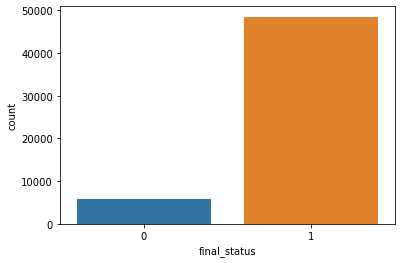

In [538]:
sns.countplot(y)

In [539]:
sm = SMOTE(random_state=42)
x, y = sm.fit_resample(x, y)

<AxesSubplot:xlabel='final_status', ylabel='count'>

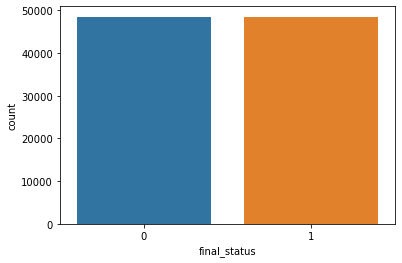

In [540]:
sns.countplot(y)

In [541]:
counter = Counter(y)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.000


In [542]:
total_positive_examples, total_negative_examples = y.value_counts()

In [543]:
total_positive_examples

48498

In [544]:
total_negative_examples

48498

In [545]:
scale_pos_weight = total_negative_examples / total_positive_examples 

In [546]:
scale_pos_weight

1.0

In [547]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [548]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54330 entries, 0 to 54329
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   store_address   54330 non-null  float64
 1   n_of_products   54330 non-null  float64
 2   products_total  54330 non-null  float64
 3   final_status    54330 non-null  int32  
 4   0               54330 non-null  float64
 5   1               54330 non-null  float64
 6   2               54330 non-null  float64
 7   3               54330 non-null  float64
 8   4               54330 non-null  float64
 9   5               54330 non-null  float64
 10  6               54330 non-null  float64
 11  7               54330 non-null  float64
 12  8               54330 non-null  float64
 13  9               54330 non-null  float64
 14  10              54330 non-null  float64
 15  11              54330 non-null  float64
 16  12              54330 non-null  float64
 17  13              54330 non-null 

##### The models

In [549]:
accuracy= []
recall =[]
roc_auc= []
precision = []
model_names =[]
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_val)

accuracy.append(round(accuracy_score(y_val, y_pred),4))
recall.append(round(recall_score(y_val, y_pred),4))
roc_auc.append(round(roc_auc_score(y_val, y_pred),4))
precision.append(round(precision_score(y_val, y_pred),4))

model_names = ['xgb']
result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df1

,Accuracy,Recall,Roc_Auc,Precision
xgb,0.8537,0.959,0.8542,0.7913


In [550]:
print(confusion_matrix(y_val, y_pred))
print("\n")
print(classification_report(y_val, y_pred))

print("Training set score for xgboost: %f" % xgb.score(x_train, y_train))
print("Testing  set score for xgboost: %f" % xgb.score(x_val, y_val))

[[7303 2442]
 [ 396 9259]]


              precision    recall  f1-score   support

           0       0.95      0.75      0.84      9745
           1       0.79      0.96      0.87      9655

    accuracy                           0.85     19400
   macro avg       0.87      0.85      0.85     19400
weighted avg       0.87      0.85      0.85     19400

Training set score for xgboost: 0.865367
Testing  set score for xgboost: 0.853711


In [551]:
accuracy= []
recall =[]
roc_auc= []
precision = []
model_names =[]
catboost_base = CatBoostClassifier(verbose=False,random_state=0, scale_pos_weight=scale_pos_weight)
catboost_base.fit(x_train, y_train, cat_features=categorical_features_indices, eval_set=(x_val, y_val))
y_pred = catboost_base.predict(x_val)

accuracy.append(round(accuracy_score(y_val, y_pred),4))
recall.append(round(recall_score(y_val, y_pred),4))
roc_auc.append(round(roc_auc_score(y_val, y_pred),4))
precision.append(round(precision_score(y_val, y_pred),4))

model_names = ['Catboost_default']
result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df1

,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.8448,0.9409,0.8453,0.7883


In [552]:
print(confusion_matrix(y_val, y_pred))
print("\n")
print(classification_report(y_val, y_pred))

print("Training set score for xgboost: %f" % xgb.score(x_train, y_train))
print("Testing  set score for xgboost: %f" % xgb.score(x_val, y_val))

[[7306 2439]
 [ 571 9084]]


              precision    recall  f1-score   support

           0       0.93      0.75      0.83      9745
           1       0.79      0.94      0.86      9655

    accuracy                           0.84     19400
   macro avg       0.86      0.85      0.84     19400
weighted avg       0.86      0.84      0.84     19400

Training set score for xgboost: 0.865367
Testing  set score for xgboost: 0.853711


In [553]:
accuracy= []
recall =[]
roc_auc= []
precision = []
lgbmc_base=LGBMClassifier(random_state=0, scale_pos_weight=scale_pos_weight)
lgbmc_base.fit(x_train, y_train, categorical_feature = 'auto', eval_set=(x_val, y_val),feature_name='auto', verbose=0)
y_pred = lgbmc_base.predict(x_val)

accuracy.append(round(accuracy_score(y_val, y_pred),4))
recall.append(round(recall_score(y_val, y_pred),4))
roc_auc.append(round(roc_auc_score(y_val, y_pred),4))
precision.append(round(precision_score(y_val, y_pred),4))

model_names = ['LightGBM_default']
result_df7 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df7

,Accuracy,Recall,Roc_Auc,Precision
LightGBM_default,0.8296,0.9695,0.8303,0.7566


In [554]:
print(confusion_matrix(y_val, y_pred))
print("\n")
print(classification_report(y_val, y_pred))

print("Training set score for xgboost: %f" % xgb.score(x_train, y_train))
print("Testing  set score for xgboost: %f" % xgb.score(x_val, y_val))

[[6734 3011]
 [ 294 9361]]


              precision    recall  f1-score   support

           0       0.96      0.69      0.80      9745
           1       0.76      0.97      0.85      9655

    accuracy                           0.83     19400
   macro avg       0.86      0.83      0.83     19400
weighted avg       0.86      0.83      0.83     19400

Training set score for xgboost: 0.865367
Testing  set score for xgboost: 0.853711


##### Engineering the test dataset

In [555]:
test.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total
0,32233784,17:50:09,MA,68169,PAID,1,61.63
1,32240990,18:38:08,ES,8220,PAID,11,15.99
2,33331821,22:11:59,IT,11169,PAID,4,5.89
3,33200505,22:13:55,AR,33371,PAID,3,7.85
4,32527480,12:01:04,TR,33958,PAID,2,4.75


In [556]:
test_enc = pd.DataFrame(ohe.transform(test[["country_code", "payment_status"]]).toarray())
test_encoded = test.join(test_enc)
test_encoded.drop(["country_code", "payment_status"], axis=1, inplace=True)
test_encoded.head()

,order_id,local_time,store_address,n_of_products,products_total,0,1,2,3,4,...,16,17,18,19,20,21,22,23,24,25
0,32233784,17:50:09,68169,1,61.63,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,32240990,18:38:08,8220,11,15.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,33331821,22:11:59,11169,4,5.89,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33200505,22:13:55,33371,3,7.85,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,32527480,12:01:04,33958,2,4.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [557]:
test_encoded['store_address']= test_encoded['store_address'].astype(float)
test_encoded['n_of_products']= test_encoded['n_of_products'].astype(float)

In [558]:
test_encoded = test_encoded.drop(["local_time"],axis=1)
test_encoded = test_encoded.drop(["order_id"],axis=1)

In [559]:
test_encoded.head()

,store_address,n_of_products,products_total,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,25
0,68169.0,1.0,61.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,8220.0,11.0,15.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,11169.0,4.0,5.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,33371.0,3.0,7.85,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,33958.0,2.0,4.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [560]:
test_encoded = test_encoded.values

In [561]:
final_pred = xgb.predict(test_encoded)

In [562]:
final_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [563]:
final_results = pd.DataFrame(final_pred)
final_results = final_results.set_axis(["final_status"], axis=1)
final_results.to_csv("results.csv", index = False)